# The Diabetes Dataset

While learning about statistical models, I've heard a lot about the diabetes dataset from Kaggle, which people use to test various ideas. I haven't seen any methods' code, though ... so I'm taking this opportunity to see how I compare to everyone else. 

Current working dataset: [Kaggle link](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset/data)

The goal here is simply to predict whether a patient will have diabetes or not, but we can do better. My goals are as follows:
- [x] Make a model which predicts if a particular patient will have diabetes
- [x] Determine the relevance of certain parameters
- [x] Trim and search for the most important parameters (spend the least money collecting data on future patients)

## Get a feel for the data set

The first thing I want to do is get a feel for the data set, then check the relationship between each of the parameters. I'll be using the `pandas` package since I'm in Jupyter for now (I can only work online since my desktop computer is out of order). 

In [8]:
import numpy as np                      ## typical numpy functions
from matplotlib import pyplot as plt    ## for visualization
import pandas as pd                     ## stats package
from os import getcwd                   ## gets the curr. work. dir (cwd) but not all of the package

cwd = getcwd()
df = pd.read_csv(f"{cwd}/diabetes_prediction_dataset.csv")  ## more reliable other systems

### Data summary

I'd like to design a quick function to make my own personal data summary as a way to refamiliarize myself with Pandas. Could be a good reference to come back to later.

**The summary should**:
- [x] Sort out various data types
- [x] Give a glimpse at the distributions of the data
- [x] Provide a starting point for looking deeper into the data

In [9]:
def selfSummary(df, maxcols = 6, flag_ignore_categoricals = False):
    ## make a summary of the data.
    ## check each type, make a graph accordingly

    ## determine if data will fit on the screen
    if len(df.columns) > maxcols:
        flag_column_cap_reached = True
        number_cols = maxcols
        number_rows = len(df.columns)//number_cols + 1
    else:
        flag_column_cap_reached = False
        number_cols = len(df.columns)
        number_rows = 1
        
    fig, axes = plt.subplots(number_rows, number_cols, figsize = (number_cols + 10, 1.5*number_rows + 1))
    plt.subplots_adjust(hspace = 0.8, wspace = 0.6)

    for i in range(0, len(df.columns)):
        current = (i//maxcols, i%maxcols)
        axes[current].set_title(df.columns[i][:7])

        ## ints & floats
        if df[df.columns[i]].dtype == 'int64' or df[df.columns[i]].dtype == 'float64':
            valx, valy = np.histogram(df[df.columns[i]])
            axes[current].stairs(valx, valy, fill = True, color = 'red')
            spread = min(valx) - max(valx)
            axes[current].set_ylim(min(valx)+0.1*spread-1, max(valx)-0.1*spread)

        ## categorical data
        if (df[df.columns[i]].dtype == 'object' or df[df.columns[i]].dtype == 'bool') and not flag_ignore_categoricals:
            stack = {}
            for obj in df[df.columns[i]]:
                if obj not in stack:
                    stack[str(obj)] = 0
                stack[str(obj)] = stack[str(obj)] + 1
            labels = [label[:2] for label in list(stack)]
            values = [stack[label] for label in stack]
            axes[current].bar(labels, values, color = 'blue')
            spread = min(values) - max(values)
            axes[current].set_ylim(min(values)-0.1*spread-1, max(values)+0.1*spread)

    ## hide any unused plots
    for i in range(len(df.columns), len(df.columns) + (maxcols - len(df.columns)%maxcols)):
        axes[i//maxcols, i%maxcols].set_axis_off()

    plt.show()

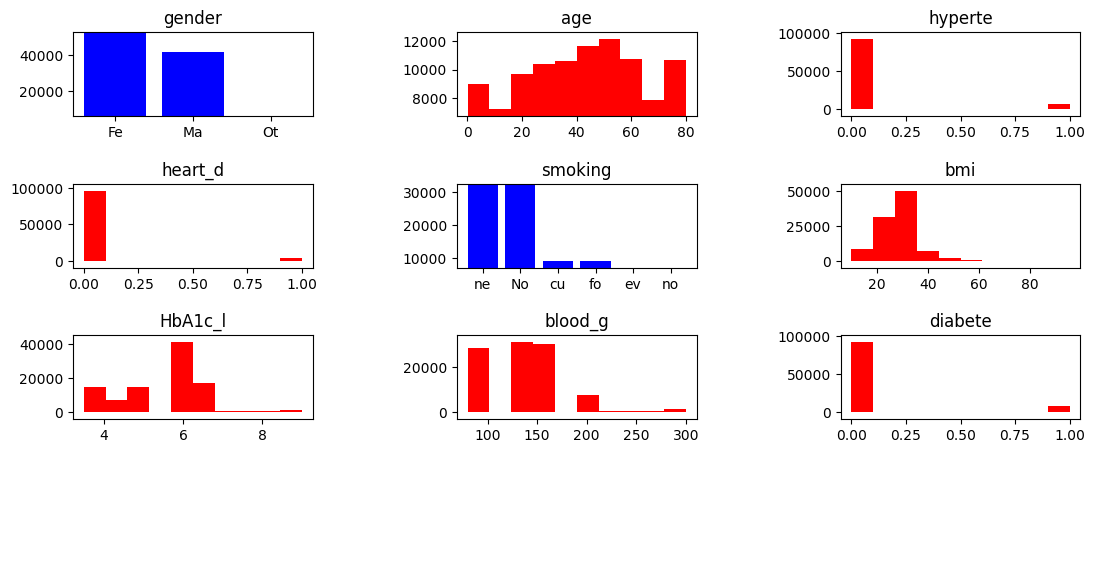

In [10]:
selfSummary(df, 3)

The summary reveals some very standard distributions. We see the near-uniform age and gender, which is always nice. We also note the odd distributions of Hb1A1c and Blood Glucose levels. I'm making a note to revisit these distributions if something odd comes up in the model. We could always load-in some other diaibetes datasets and see if they have disparaging distributions. 

Hb1A1c is described to be similar to the "average blood-glucose levels over the past few months". This, in combination with blood-glucose levels, will hopefully prove valuable. Since diabetes affects the amount of glucose in the blood, I hypothesize these to be good indiactors when making the model. 

Let's quit yapping and see if there are any obvious correlations. 

### Correlations with Target

While I have some mathematical quarrels with just straight-up calculating the correlation (due to the target variable being boolean), it is technically Bernoulii, with 1 := 'diabetes' and 0 := 'no diabetes'. This means the best estimator is still the sample average, so using correlation should still hold up. 

The `pandas` library provides a standard `corr()` function for this. After reveiwing the source, I have verified it is exactly what I'm looking for. Although, it doesn't like the use of categoricals. I'll have to port everything over. I had to use a quick custom method since the Pandas one was giving me issues.

In [46]:
new_df_labels = []
for label in df.columns:
    if df[label].dtype != 'object':
        new_df_labels.append(label)
newdf = df[new_df_labels]

In [49]:
newdf.corr()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.251171,0.233354,0.337396,0.101354,0.110672,0.258008
hypertension,0.251171,1.000000,0.121262,0.147666,0.080939,0.084429,0.197823
heart_disease,0.233354,0.121262,1.000000,0.061198,0.067589,0.070066,0.171727
bmi,0.337396,0.147666,0.061198,1.000000,0.082997,0.091261,0.214357
HbA1c_level,0.101354,0.080939,0.067589,0.082997,1.000000,0.166733,0.400660
blood_glucose_level,0.110672,0.084429,0.070066,0.091261,0.166733,1.000000,0.419558
diabetes,0.258008,0.197823,0.171727,0.214357,0.400660,0.419558,1.000000


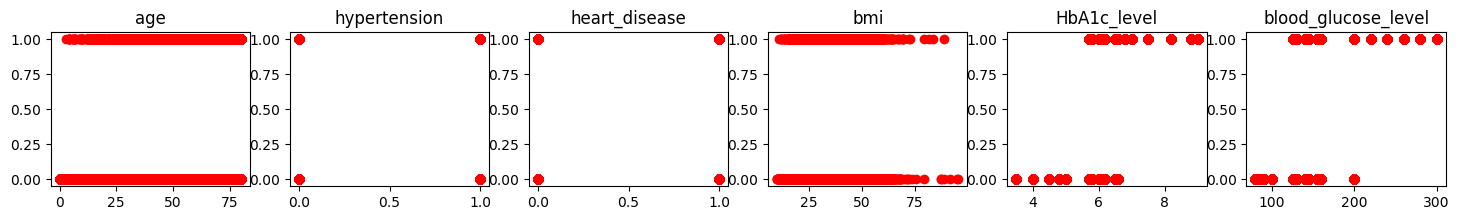

In [65]:
label_list = newdf.columns

fig, ax = plt.subplots(1, len(label_list)-1, figsize = (18, 2))

for i in range(0, len(label_list)-1):
    ax[i].plot(newdf[newdf.columns[i]], newdf.diabetes, 'ro')
    ax[i].set_title(str(newdf.columns[i]))

#### Results from correlation testing.

We immediately notice two things:
1. I forgot that 'hyptertension' and 'heart disease' were *also* categorical. These are Bernoulli variables, so it is possible to make a model that includes them, but that will come later, because of point number two.
2. HbA1c levels & blood-glucose levels are the primary predictors of those with diabetes (as predicted). This is basically screaming for us to approach this with a logisitc curve.

It's worth noting that HbA1c and blood-glucose are closely-related measurements, and hence correlated. We'll keep this in mind as we make our model.

### Making a logistic model

Let's jump into making a logistic model. This is one of my favorite models for its immedaite feedback and broad usefulness. We could get into the weeds and make our own model, but we'll stick to using SKL's for now.

Since a logisitc model requires independent random variables, we can't use HbA1c & blood-glucose at the same time. To get around this, let's fit two models and compare them. We could even 'wire them in series' down the line and see how that affects accuracy. 

In [68]:
## checking version, haven't used in a while
import sklearn as skl
skl.__version__

'1.5.2'

In [141]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def newModel(split_rate, rs = 314): ## just saves some time
    H_model = {'colname': 'HbA1c_level'}
    bg_model = {'colname': 'blood_glucose_level'}
    for obj in [H_model, bg_model]:
        obj['x_train'], obj['x_test'], obj['y_train'], obj['y_test'] = train_test_split(
            pd.DataFrame(df[obj['colname']]),   ## X data
                                                 # new version problems?
                                                 # had to ensure df with 1 col for the LogReg class
            df.diabetes,                        ## y data
            test_size = split_rate,             ## where to split data
            random_state = rs                   ## to recreate results if needed
        )
        
        obj['logreg'] = LogisticRegression(random_state = rs)
        obj['logreg'].fit(obj['x_train'], obj['y_train'])
        obj['y_pred'] = obj['logreg'].predict(obj['x_test'])

        obj['cnf'] = skl.metrics.confusion_matrix(obj['y_test'], obj['y_pred'])

    return (H_model, bg_model)

[]

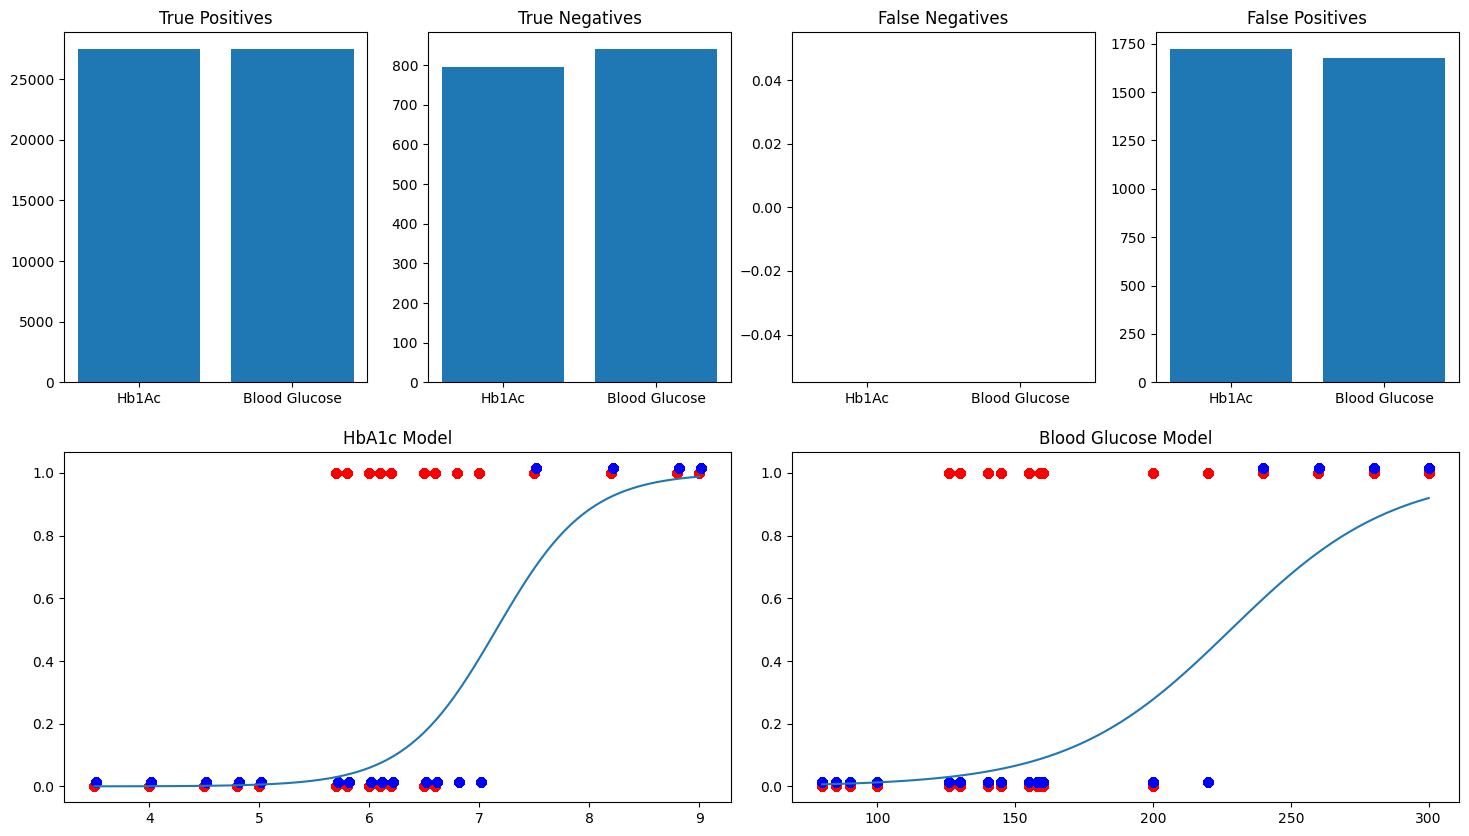

In [253]:
H, bg = newModel(0.3, 314)

fig, axes = plt.subplots(2, 4, figsize = (18, 10))

axes[0][0].set_title("True Positives")
axes[0][0].bar(['Hb1Ac', 'Blood Glucose'], [H['cnf'][0][0], bg['cnf'][0][0]])
axes[0][1].set_title("True Negatives")
axes[0][1].bar(['Hb1Ac', 'Blood Glucose'], [H['cnf'][1][1], bg['cnf'][1][1]])
axes[0][2].set_title("False Negatives")
axes[0][2].bar(['Hb1Ac', 'Blood Glucose'], [H['cnf'][0][1], bg['cnf'][0][1]])
axes[0][3].set_title("False Positives")
axes[0][3].bar(['Hb1Ac', 'Blood Glucose'], [H['cnf'][1][0], bg['cnf'][1][0]])

gs = axes[1,0].get_gridspec()
for ax in axes[1,:]:
    ax.remove()
bigaxes = [fig.add_subplot(gs[1,0:2]), fig.add_subplot(gs[1,2:4])]

shift = 0.015   ## to make all points visible

bigaxes[0].set_title("HbA1c Model")
bigaxes[0].plot(H['x_test'], H['y_test'], 'ro')
bigaxes[0].plot(H['x_test'] + shift, H['y_pred'] + shift, 'bo')

xlist = np.linspace(min(H['x_test'].HbA1c_level), max(H['x_test'].HbA1c_level), 100)
bigaxes[0].plot( xlist, 1/(1 + np.exp( -H['logreg'].intercept_ -H['logreg'].coef_[0] * xlist) ) )

bigaxes[1].set_title("Blood Glucose Model")
bigaxes[1].plot(bg['x_test'], bg['y_test'], 'ro')
bigaxes[1].plot(bg['x_test'] + shift, bg['y_pred'] + shift, 'bo')

xlist = np.linspace(min(bg['x_test'].blood_glucose_level), max(bg['x_test'].blood_glucose_level), 100)
bigaxes[1].plot( xlist, 1/(1 + np.exp( -bg['logreg'].intercept_ -bg['logreg'].coef_[0] * xlist) ) )

plt.plot()

## Conclusions about the linear regression model

We see that both the HbA1c and the blood glucose levels are good predictors of if a patient will have diabetes or not. To imrpvoe the model further, we can try and create a two-dimensionsal logisitc regression utilizing both, but we'd need to first "remove" their dependencies. That is, try and remove as much correlation from these variables as possible. This could either end up making the model way better, or destroy its accuracy and meaning. 

This was a great experience to get back into working with SKL on Jupyter. I have a ton of other ideas to get working on. For now, I'm pretty happy with this simple model. We'll have to get into ANOVA and get serious about other parameters somehwere down the line. 

In [247]:
- H['logreg'].coef_ - xlist
np.shape(- H['logreg'].coef_[0] - xlist)

(100,)